# Example 2: 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

## Imports

First, we need to import all modules we later want to use.

In [2]:
%matplotlib inline

from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

## MC - GLM Model Changes

To run different models, task data is now stored in its own folders, i.e. data/models/{model}/sub--run--task etc. 

In [3]:

model = 'self_other'

experiment_dir = opj('/output', model)

output_dir = 'datasink'
working_dir = 'workingdir'


# list of subject identifiers
subject_list = ['sub-222', 'sub-256', 'sub-270']

# TR of functional images
with open('/data/task-emp_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]
run = [1 , 2, 3, 4]

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [10]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [11]:
# Condition names
condition_names = ['self', 'other']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/2., 1/2.]]
cont02 = ['self',         'T', condition_names, [1, 0]]
cont03 = ['other',           'T', condition_names, [0, 1]]
cont04 = ['self > other','T', condition_names, [1, -1]]
cont05 = ['other > self',  'T', condition_names, [-1, 1]]

cont08 = ['activation',     'F', [cont02, cont03]]
cont09 = ['differences',    'F', [cont04, cont05]]

contrast_list = [cont01, cont02, cont03, cont04, cont05]


## Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

Now, let us incorporate all this in the helper function ``subjectinfo``.

In [19]:
def subjectinfo(subject_id):    
    
    model = 'self_other'
    
    
    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    #trialinfo = pd.read_table('/data/' + subject_id + '/func/' + subject_id + '_task-emp_run-01_events.tsv')
    trialinfo = pd.read_table('/data/models/' + model + '/' +  subject_id + '_task-emp_run-01_events.tsv')

    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby(model):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')



## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [20]:

###hardcoded templates, have to fix

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts',
                                            'runs'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm), 
                        ('run', run)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_s{subject_id}_task-emp_run-01_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                             '{subject_id}_task-emp_run-01_bold.par'),
             'outliers': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}', 
                             'art.{subject_id}_task-emp_run-01_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'emp'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [21]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

170927-19:15:10,942 workflow INFO:
	 Generated workflow graph: /output/self_other/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).
170927-19:15:11,280 workflow INFO:
	 Generated workflow graph: /output/self_other/workingdir/l1analysis/graph.dot.png (graph2use=flat, simple_form=True).


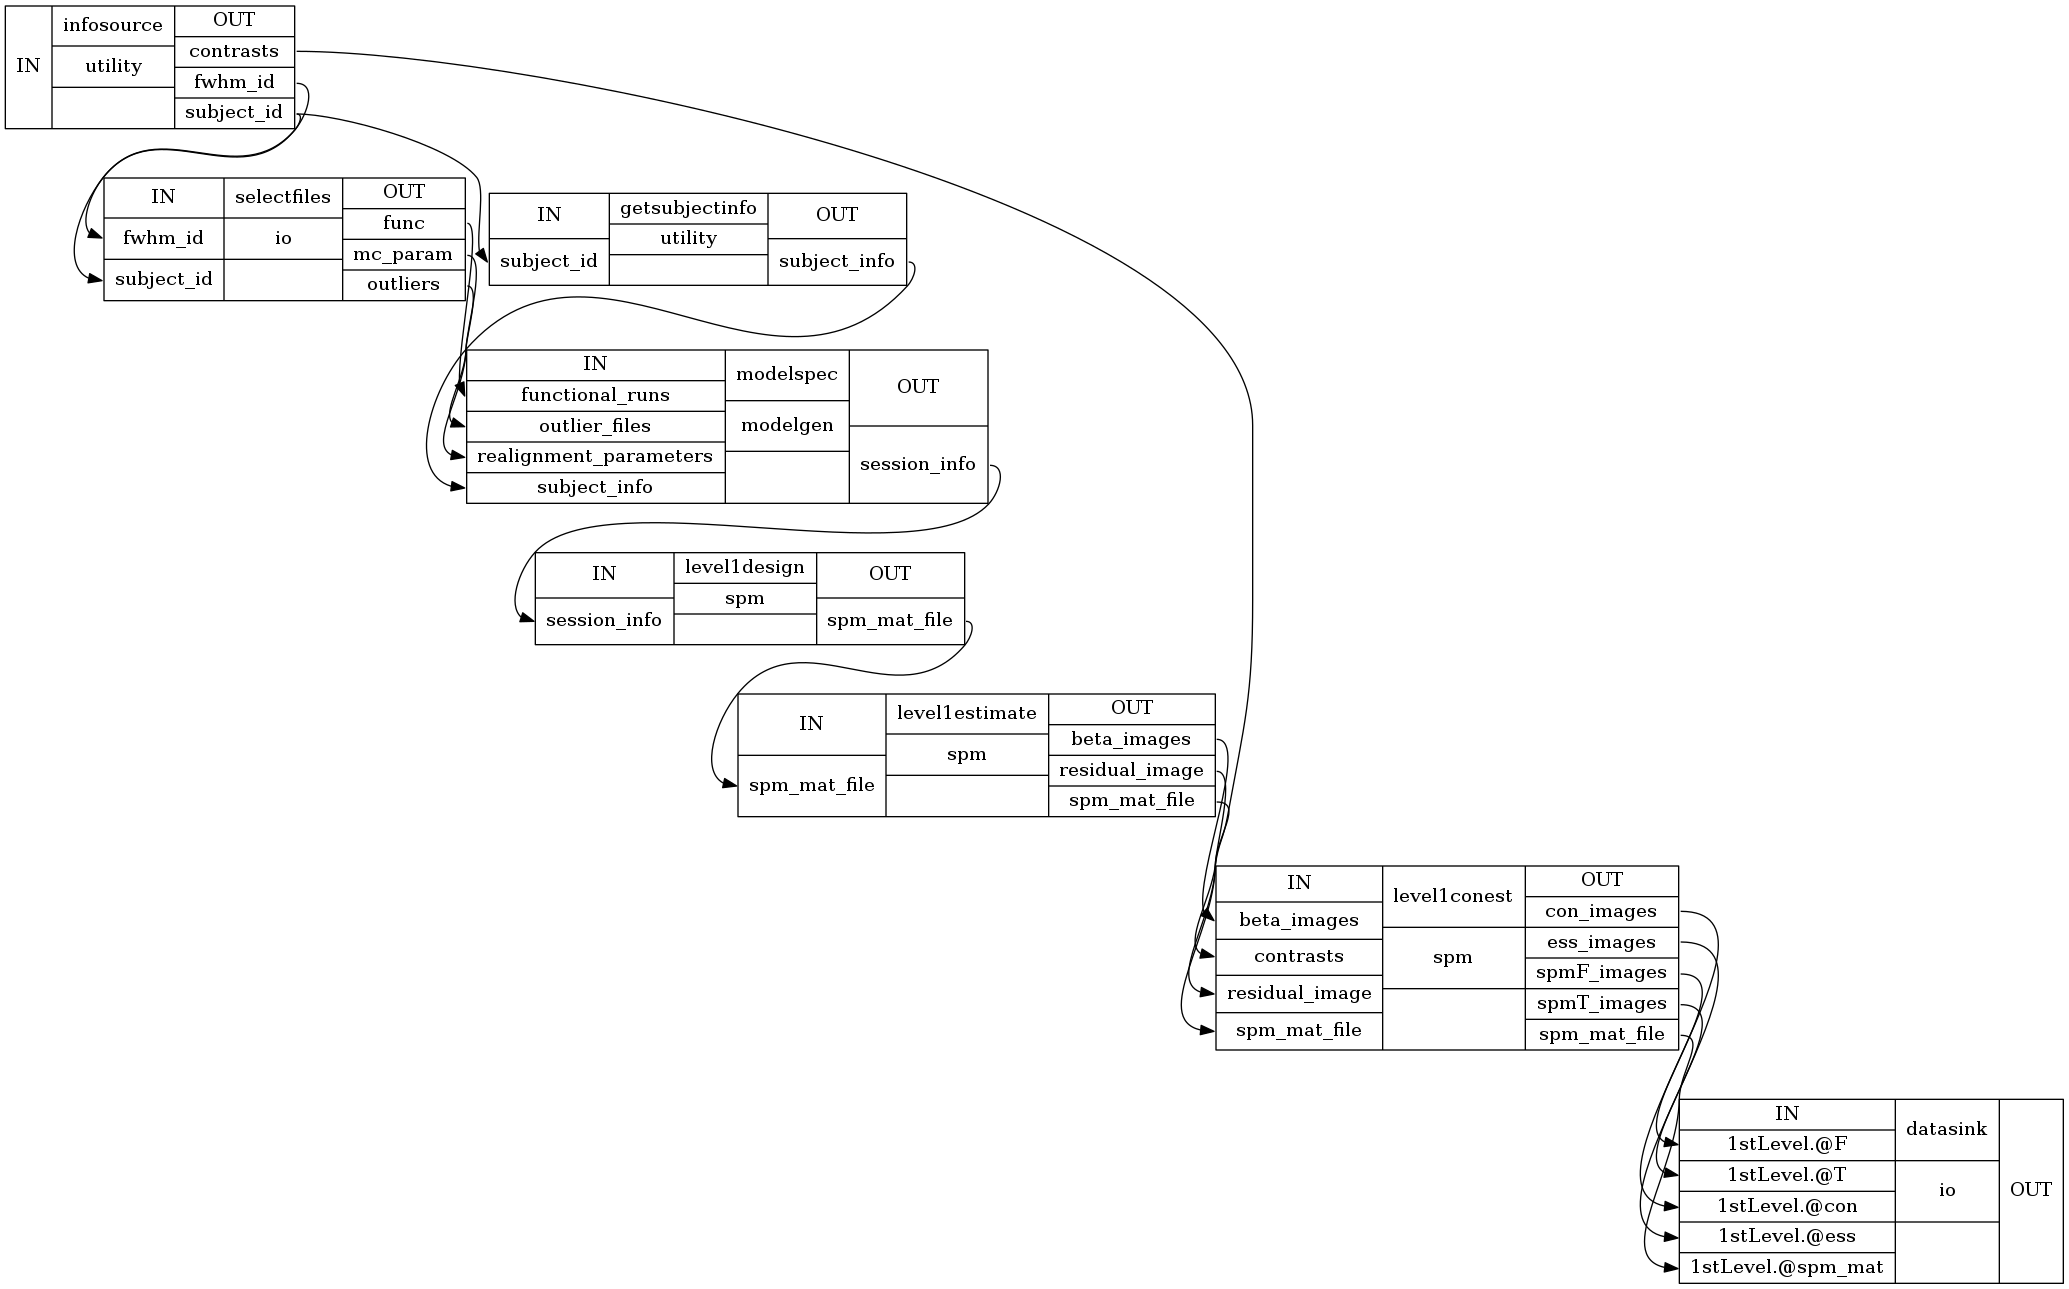

In [22]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))


l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [24]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

170927-19:17:00,0 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170927-19:17:00,93 workflow INFO:
	 Running in parallel.
170927-19:17:00,98 workflow INFO:
	 Executing: getsubjectinfo.a5 ID: 0
170927-19:17:00,111 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a5 jobid: 0
170927-19:17:00,114 workflow INFO:
	 Executing: selectfiles.a5 ID: 1
170927-19:17:00,125 workflow INFO:
	 Executing: getsubjectinfo.a4 ID: 7
170927-19:17:00,132 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a4 jobid: 7
170927-19:17:00,134 workflow INFO:
	 Executing: selectfiles.a4 ID: 8
170927-19:17:00,129 workflow INFO:
	 Executing node selectfiles.a5 in dir: /output/self_other/workingdir/l1analysis/_fwhm_id_8_subject_id_sub-270/selectfiles
170927-19:17:00,162 workflow INFO:
	 Executing node selectfiles.a4 in dir: /output/self_other/workingdir/l1analysis/_fwhm_id_4_subject_id_sub-270/selectfiles
170927-19:17:00,264 workflow INFO:
	 [Job finished] jobname: selectfile

170927-19:21:40,111 workflow INFO:
	 Executing: datasink.a3 ID: 20
170927-19:21:40,220 workflow INFO:
	 Executing node datasink.a3 in dir: /output/self_other/workingdir/l1analysis/_fwhm_id_8_subject_id_sub-256/datasink
170927-19:21:40,310 interface INFO:
	 sub: /output/self_other/datasink/1stLevel/_fwhm_id_8_subject_id_sub-256/SPM.mat -> /output/self_other/datasink/1stLevel/sub-256/fwhm-8/SPM.mat
170927-19:21:40,340 interface INFO:
	 sub: /output/self_other/datasink/1stLevel/_fwhm_id_8_subject_id_sub-256/spmT_0001.nii -> /output/self_other/datasink/1stLevel/sub-256/fwhm-8/spmT_0001.nii
170927-19:21:40,368 interface INFO:
	 sub: /output/self_other/datasink/1stLevel/_fwhm_id_8_subject_id_sub-256/spmT_0002.nii -> /output/self_other/datasink/1stLevel/sub-256/fwhm-8/spmT_0002.nii
170927-19:21:40,391 interface INFO:
	 sub: /output/self_other/datasink/1stLevel/_fwhm_id_8_subject_id_sub-256/spmT_0003.nii -> /output/self_other/datasink/1stLevel/sub-256/fwhm-8/spmT_0003.nii
170927-19:21:40,430 i

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [26]:


!tree /output/self_other/datasink/1stLevel

/output/self_other/datasink/1stLevel
|-- sub-222
|   |-- fwhm-4
|   |   |-- SPM.mat
|   |   |-- con_0001.nii
|   |   |-- con_0002.nii
|   |   |-- con_0003.nii
|   |   |-- con_0004.nii
|   |   |-- con_0005.nii
|   |   |-- spmT_0001.nii
|   |   |-- spmT_0002.nii
|   |   |-- spmT_0003.nii
|   |   |-- spmT_0004.nii
|   |   `-- spmT_0005.nii
|   `-- fwhm-8
|       |-- SPM.mat
|       |-- con_0001.nii
|       |-- con_0002.nii
|       |-- con_0003.nii
|       |-- con_0004.nii
|       |-- con_0005.nii
|       |-- spmT_0001.nii
|       |-- spmT_0002.nii
|       |-- spmT_0003.nii
|       |-- spmT_0004.nii
|       `-- spmT_0005.nii
|-- sub-256
|   |-- fwhm-4
|   |   |-- SPM.mat
|   |   |-- con_0001.nii
|   |   |-- con_0002.nii
|   |   |-- con_0003.nii
|   |   |-- con_0004.nii
|   |   |-- con_0005.nii
|   |   |-- spmT_0001.nii
|   |   |-- spmT_0002.nii
|   |   |-- spmT_0003.nii
|   |   |-- spmT_0004.nii
|   |   `-- spmT_0005.nii
|   `-- fwhm-8
|       |-- SPM.mat
|       |-- con_0001.nii
|       |

## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

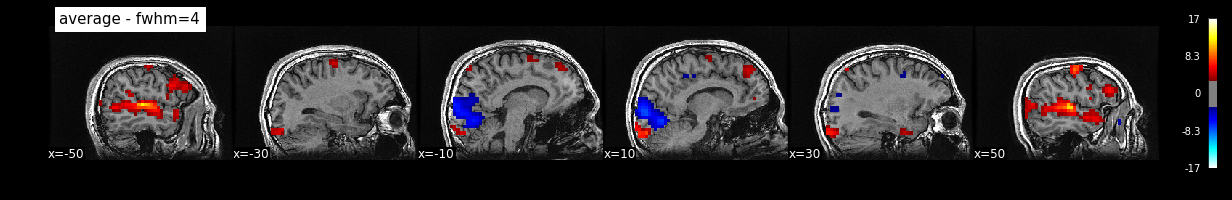

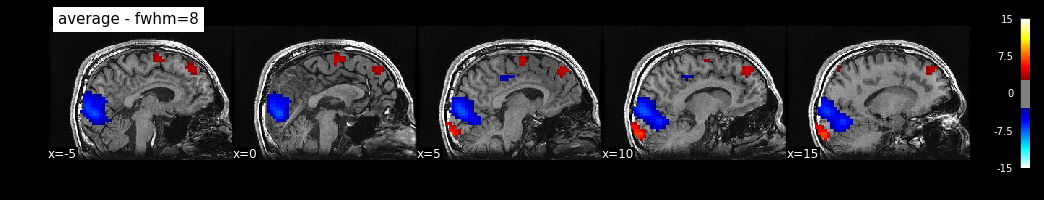

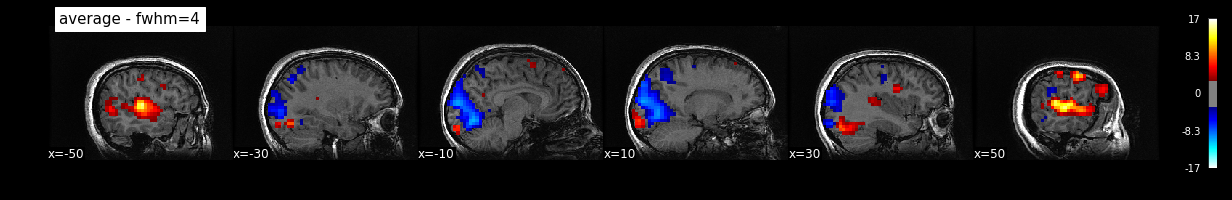

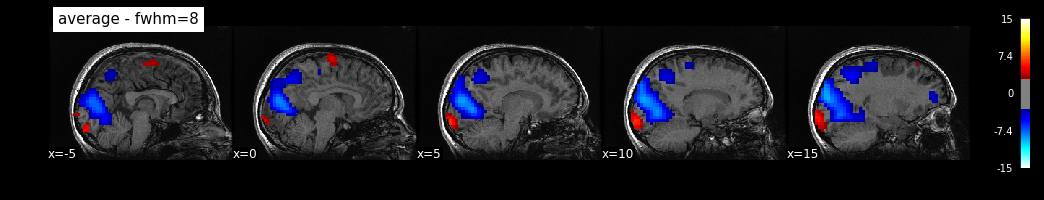

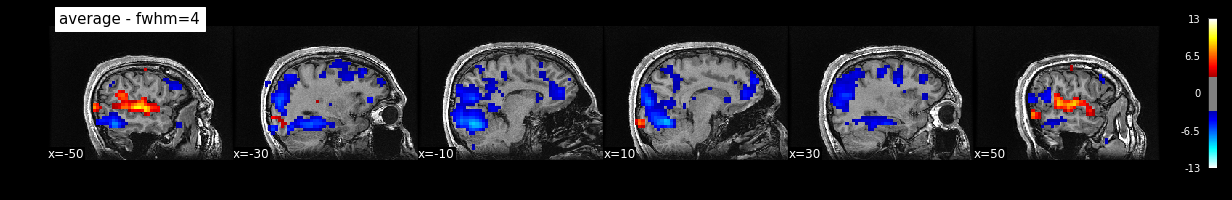

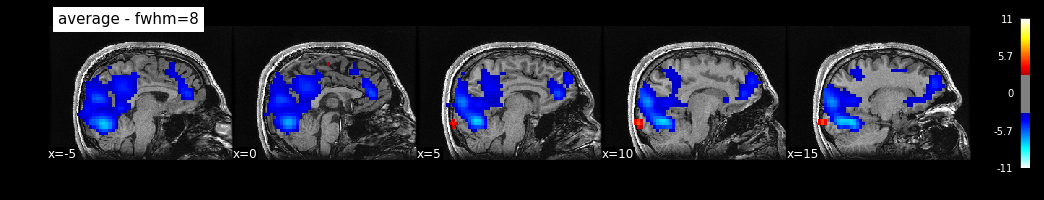

In [41]:
from nilearn.plotting import plot_stat_map



for subject_id in subject_list:
    anatimg = '/data/derivatives/fmriprep/' + subject_id + '/anat/' + subject_id  + '_t1w_preproc.nii.gz'
    plot_stat_map(
        '/output/datasink/1stLevel/' + subject_id + '/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
        bg_img=anatimg, threshold=3, display_mode='x', cut_coords=(-50, -30, -10, 10, 30, 50), dim=-1)
    plot_stat_map(
        '/output/datasink/1stLevel/' + subject_id + '/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
        bg_img=anatimg, threshold=3, display_mode='x', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

Now, let's look at the three contrasts **`Finger`**, **`Foot`**, **`Lips`**.

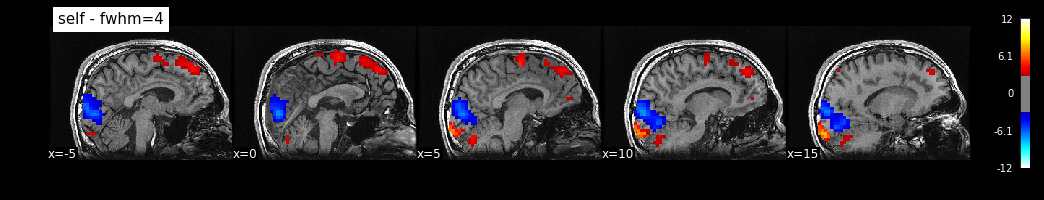

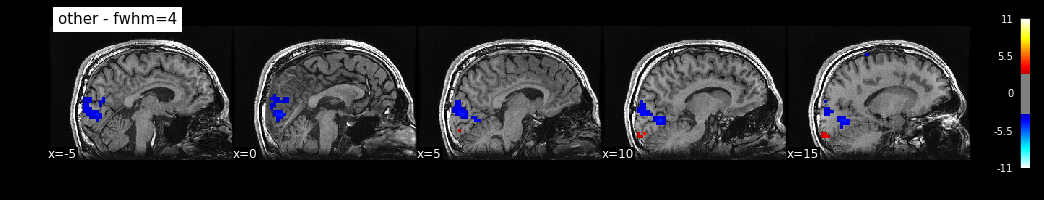

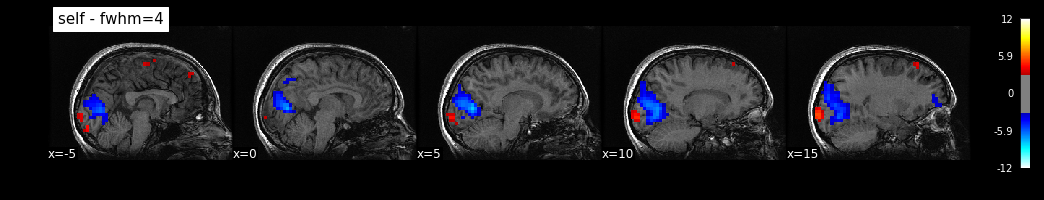

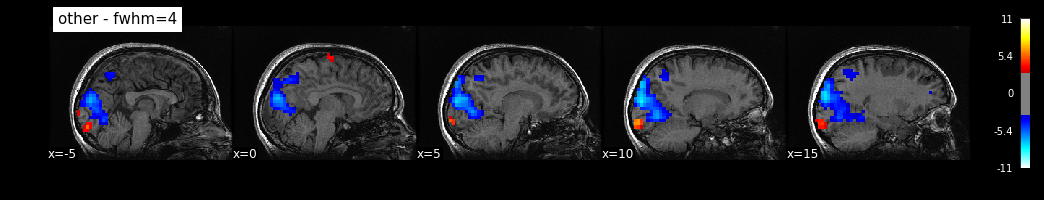

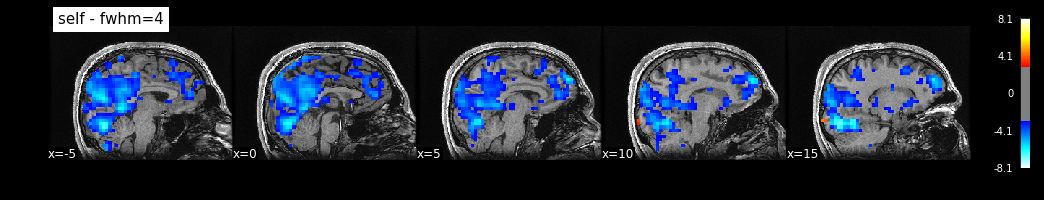

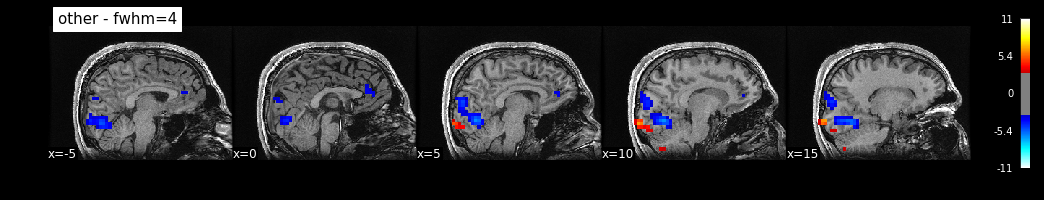

In [34]:

for subject_id in subject_list:
    anatimg = '/data/derivatives/fmriprep/' + subject_id + '/anat/' + subject_id  + '_t1w_preproc.nii.gz'

    plot_stat_map(
        '/output/datasink/1stLevel/' + subject_id + '/fwhm-4/spmT_0002.nii', title='self - fwhm=4',
        bg_img=anatimg, threshold=3, display_mode='x', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
    plot_stat_map(
        '/output/datasink/1stLevel/' + subject_id + '/fwhm-4/spmT_0003.nii', title='other - fwhm=4',
        bg_img=anatimg, threshold=3, display_mode='x', cut_coords=(-5, 0, 5, 10, 15), dim=-1)


We can also check three additional contrasts **Finger > others**, **Foot > others** and **Lips > others**. 

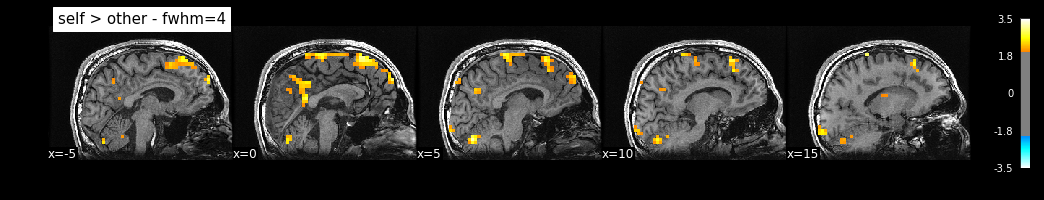

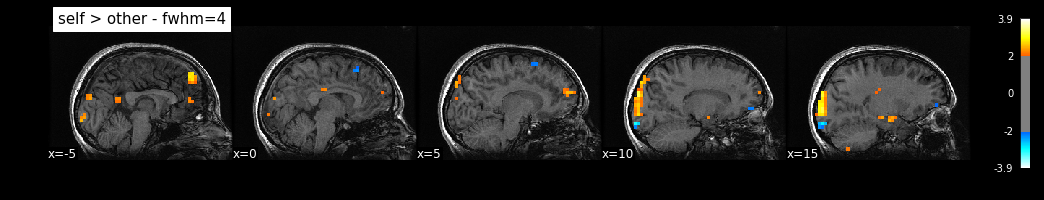

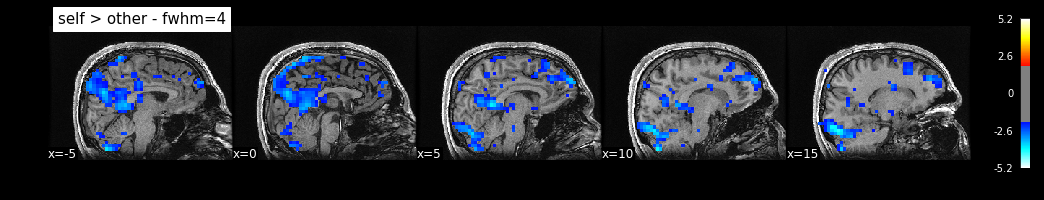

In [36]:
for subject_id in subject_list:
    anatimg = '/data/derivatives/fmriprep/' + subject_id + '/anat/' + subject_id  + '_t1w_preproc.nii.gz'
    plot_stat_map(
        '/output/datasink/1stLevel/' + subject_id + '/fwhm-4/spmT_0004.nii', title='self > other - fwhm=4',
        bg_img=anatimg, threshold=2, display_mode='x', cut_coords=(-5, 0, 5, 10, 15), dim=-1)
    #plot_stat_map(
    #    '/output/datasink/1stLevel/' + subject_id + '/fwhm-4/spmT_0005.nii', title='other > self - fwhm=4',
    #    bg_img=anatimg, threshold=2, display_mode='x', cut_coords=(-5, 0, 5, 10, 15), dim=-1)